# 1. Importing Libraries #

In [ ]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# System libraries
from pathlib import Path
import os.path
from distutils.dir_util import copy_tree, remove_tree
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
import time

from PIL import Image
from random import randint

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121

# 2. Datasets #

In [ ]:
train = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"
test = "/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset"

In [ ]:
image_dir = Path(train)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
def get_dataset(augmented = 0):
    if(augmented == 0):
        image_dir = Path(test)
    else:
        image_dir = Path(train)
        
    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

In [ ]:
train_df = get_dataset(1)
test_df = get_dataset(0)

In [ ]:
pd.set_option('display.max_colwidth', None)
train_df.head()

In [ ]:
test_df.tail()

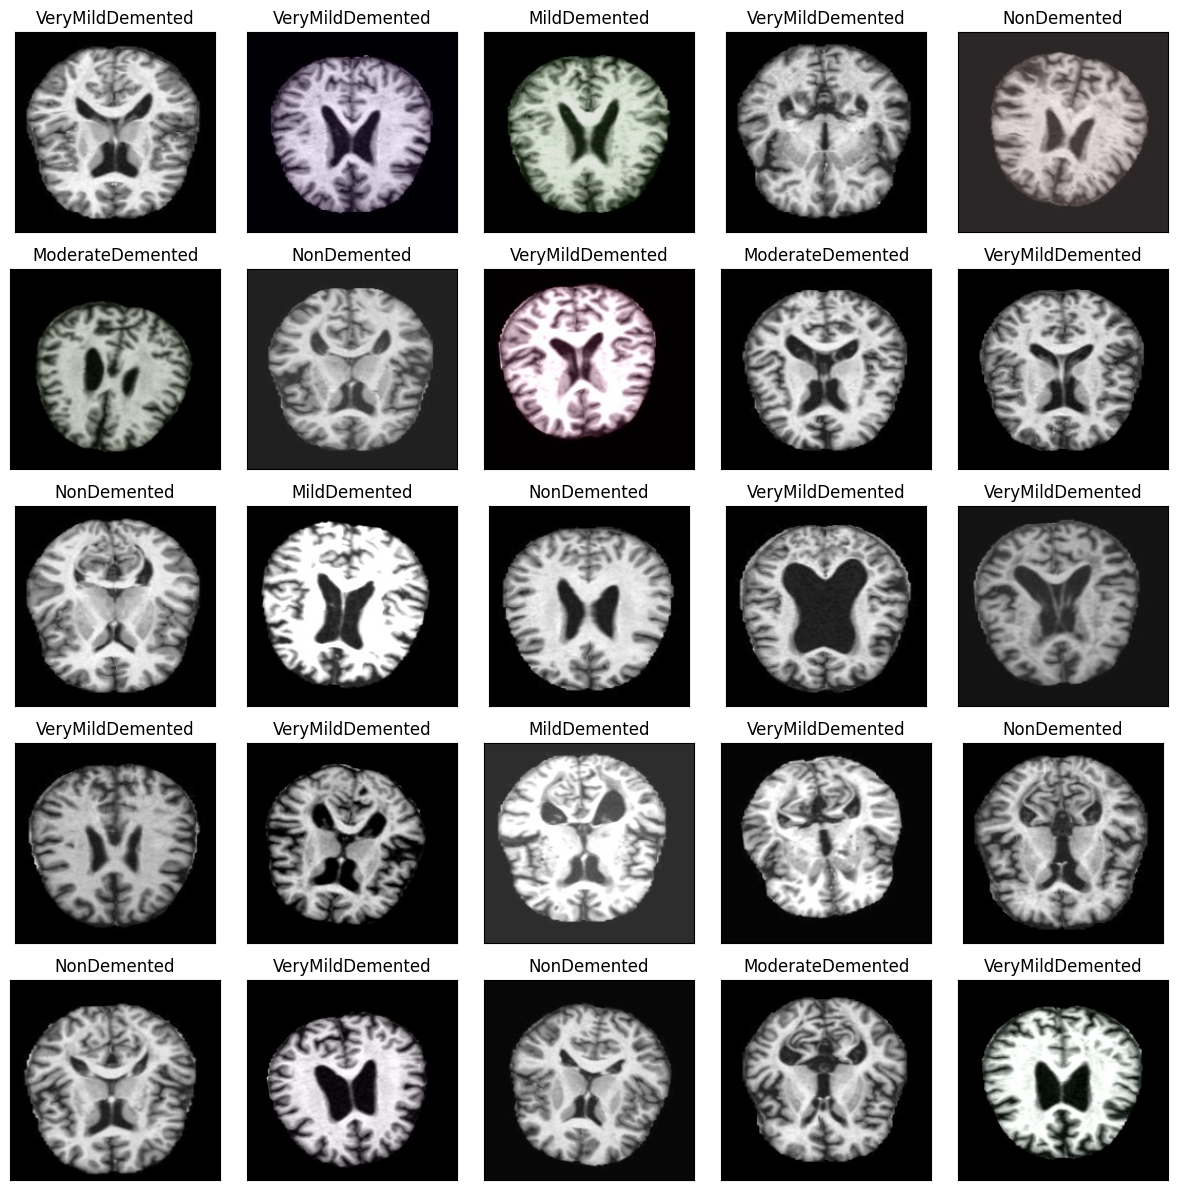

In [8]:
# Display 25 picture of the augmented dataset with their labels
random_index = np.random.randint(0, len(train_df), 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(plt.imread(train_df.Filepath[random_index[i]]), cv2.COLOR_BGR2RGB))
    ax.set_title(train_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

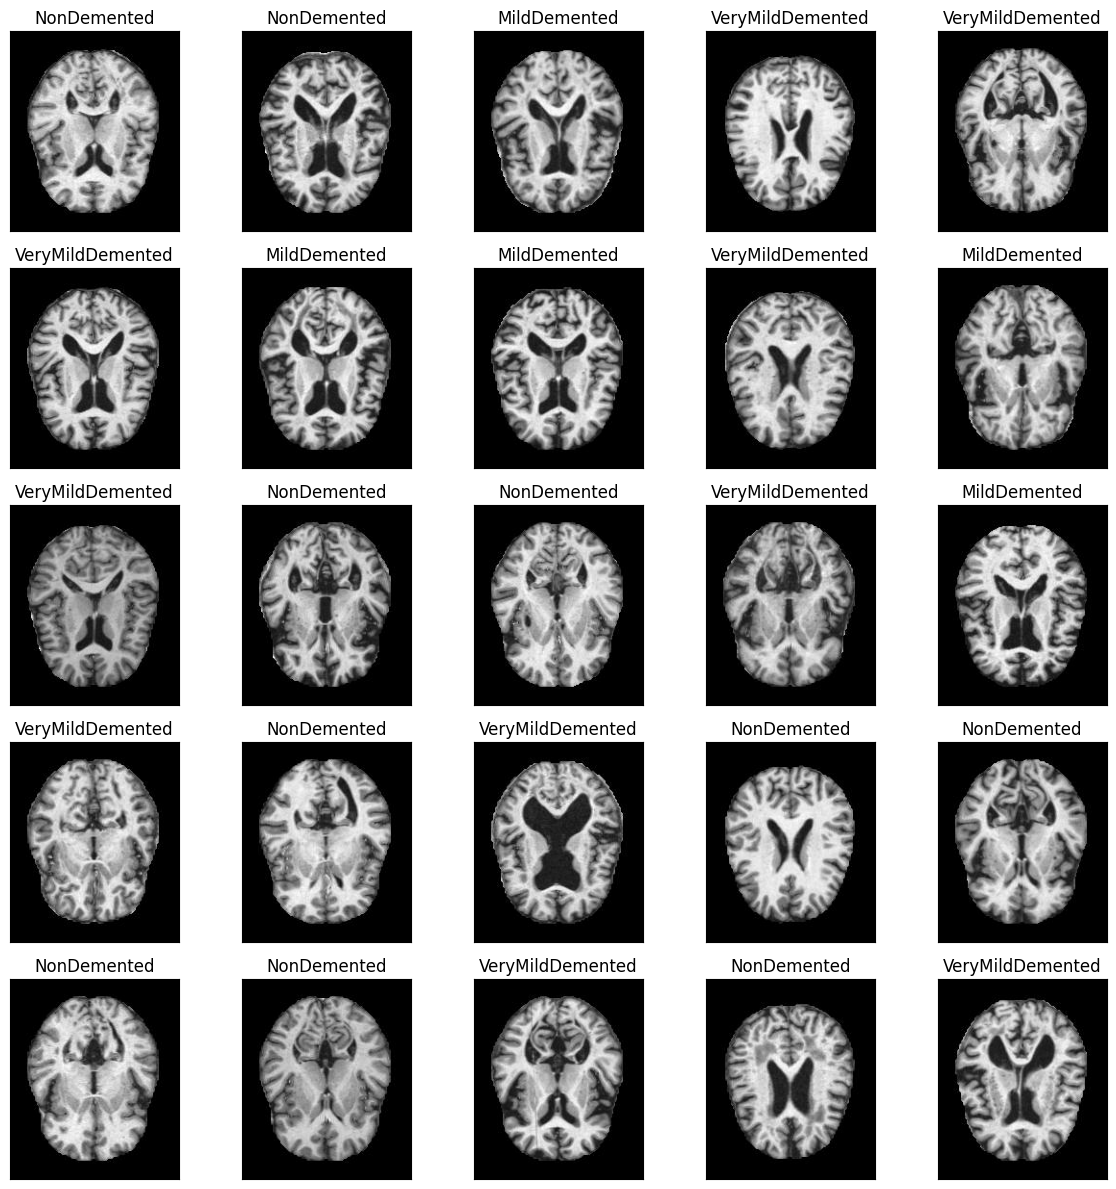

In [9]:
# Display 25 picture of the original dataset with their labels
random_index = np.random.randint(0, len(test_df), 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(plt.imread(test_df.Filepath[random_index[i]]), cv2.COLOR_BGR2RGB))
    ax.set_title(test_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [10]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [11]:
datagen = IDG(rescale = 1./255, validation_split=0.1)

train_gen = datagen.flow_from_directory(directory=train,
                                             target_size=DIM,
                                             batch_size=400,
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True)

validation_gen = datagen.flow_from_directory(directory=train,
                                             target_size=DIM,
                                             batch_size=400,
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=True)

test_gen = datagen.flow_from_directory(directory=test,
                                             target_size=DIM,
                                             batch_size=6400,
                                             class_mode='categorical')

Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [12]:
test_gen_plot = datagen.flow_from_directory(directory=test,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='categorical')

Found 6400 images belonging to 4 classes.


In [13]:
models_accuracy = dict()

In [14]:
def plot_training_metrics(train_hist, model, test_gen_plot, y_actual, y_pred, classes, model_name):
    
    # Evaluate the results:
    test_metrics = model.evaluate(test_gen_plot, verbose = False)
    AUC       = test_metrics[1]*100
    Acc       = test_metrics[2]*100 
    results_title =(f"\n Model AUC {AUC:.2f}%, Accuracy {Acc:.2f}% on Test Data\n")
    print(results_title.format(AUC, Acc))
    models_accuracy[model_name] = Acc
    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(12,4))
    
    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    plt.plot(epochs,[AUC/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()

    
     # calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title(f"Confusion Matrix \nAUC: {AUC:.2f}%")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [15]:
def prepare_for_test(model, test_gen):
    data, y_true = test_gen.__next__()
    y_pred_ = model.predict(data, batch_size = 64)
    y_pred = []
    for i in range(y_pred_.shape[0]):
        y_pred.append(np.argmax(y_pred_[i]))
        
    y_true = np.argmax(y_true, axis=1)
    
    return y_true, y_pred

# 3. Models #

## 3.1. VGG19 ##

In [ ]:
vgg = VGG19(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

In [ ]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
steps_per_epoch=len(train_gen)
validation_steps=len(validation_gen)
history = model.fit(train_gen,
                    validation_data=validation_gen,
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

## 3.2. VGG16 ##

In [ ]:
vgg = VGG16(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

In [20]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
steps_per_epoch=len(train_gen)
validation_steps=len(validation_gen)
history = model.fit(train_gen,
                    validation_data=validation_gen,
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 75s 862ms/step - acc: 0.4706 - auc: 0.7249 - loss: 1.2184 - val_acc: 0.7204 - val_auc: 0.9252 - val_loss: 0.7237
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 73s 874ms/step - acc: 0.7438 - auc: 0.9329 - loss: 0.6880 - val_acc: 0.7760 - val_auc: 0.9484 - val_loss: 0.5929
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 68s 818ms/step - acc: 0.7873 - auc: 0.9531 - loss: 0.5740 - val_acc: 0.7964 - val_auc: 0.9579 - val_loss: 0.5302
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 69s 820ms/step - acc: 0.8098 - auc: 0.9623 - loss: 0.5144 - val_acc: 0.8234 - val_auc: 0.9680 - val_loss: 0.4777
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 69s 827ms/step - acc: 0.8366 - auc: 0.9716 - loss: 0.4557 - val_acc: 0.8376 - val_auc: 0.9721 - val_loss: 0.4443
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 71s 838ms/step - acc: 0.8470 - auc: 0.9753 - loss: 0.4259 - val_acc: 0.8476 - val_auc: 0.9751 - val_loss: 0.4209
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 68s 811ms/step - acc: 0.8693 - auc: 0.9809 - loss: 0.388

100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step

 Model AUC 99.67%, Accuracy 94.89% on Test Data

              precision    recall  f1-score   support

        mild       0.96      0.97      0.96       896
    moderate       1.00      1.00      1.00        64
      normal       0.97      0.94      0.95      3200
   very-mild       0.92      0.95      0.93      2240

    accuracy                           0.95      6400
   macro avg       0.96      0.97      0.96      6400
weighted avg       0.95      0.95      0.95      6400



<ipython-input-14-a8fb08ff585c>:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


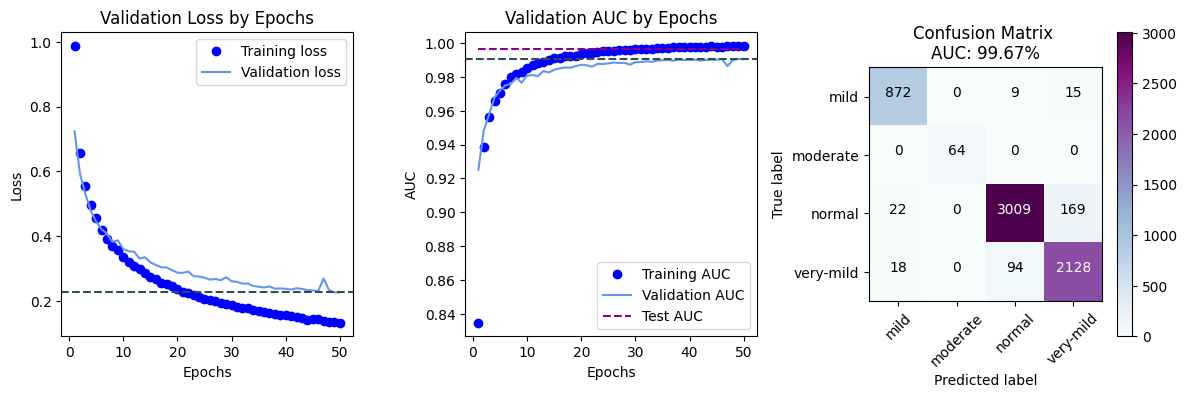

In [21]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "VGG16")

## 3.3. ResNet50 ##

In [22]:
rn = ResNet50(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in rn.layers:
    layer.trainable = False
x = Flatten()(rn.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=rn.input, outputs=prediction)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 176, 176, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 182, 182, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 88, 88, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 88, 88, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 88, 88, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 90, 90, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 44, 44, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 44, 44, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 44, 44, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 44, 44, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 44, 44, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 44, 44, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 44, 44, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 44, 44, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 44, 44, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,882,628 (91.10 MB)

 Trainable params: 294,916 (1.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
steps_per_epoch=len(train_gen)
validation_steps=len(validation_gen)
history = model.fit(train_gen,
                    validation_data=validation_gen,
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/50


In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "ResNet50")

## 3.4. Xception ##

In [ ]:
model = Xception(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)
model.summary()

In [ ]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
steps_per_epoch=len(train_gen)
validation_steps=len(validation_gen)
history = model.fit(train_gen,
                    validation_data=validation_gen,
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "Xception")

## 3.5. MobileNet ##

In [ ]:
model = MobileNet(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)
model.summary()

In [ ]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
steps_per_epoch=len(train_gen)
validation_steps=len(validation_gen)
history = model.fit(train_gen,
                    validation_data=validation_gen,
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "MobileNet")

## 3.6. DenseNet121 ##

In [ ]:
model = DenseNet121(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)
model.summary()

In [ ]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
steps_per_epoch=len(train_gen)
validation_steps=len(validation_gen)
history = model.fit(train_gen,
                    validation_data=validation_gen,
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "DenseNet121")

## 3.7. InceptionV3

In [ ]:
model = InceptionV3(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)
model.summary()

In [ ]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
steps_per_epoch=len(train_gen)
validation_steps=len(validation_gen)
history = model.fit(train_gen,
                    validation_data=validation_gen,
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "InceptionV3")

# 4. Comparison of Models #

In [ ]:
models_accuracy_df = pd.DataFrame(models_accuracy, index=['Accuracy'])
scores_df = pd.concat([models_accuracy_df])
scores_df